In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


2024-05-22 01:13:54.387745: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import scipy.io
# Load the .mat file
file_path = '../EV_Rank_1_52_RBs_50_UEs_1000_snaps.mat'
data = scipy.io.loadmat(file_path)

# Extract the relevant data
EV_data = data['EV_re_im_split']

# Check the shape and structure of the extracted data
data = EV_data
del EV_data
data.shape

(50, 1000, 832)

In [3]:
# Create sequences
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(data.shape[0]):
        for j in range(data.shape[1] - n_steps_in - n_steps_out + 1):
            X.append(data[i, j:j+n_steps_in, :])
            y.append(data[i, j+n_steps_in:j+n_steps_in+n_steps_out, :])
    return np.array(X), np.array(y)



In [4]:

n_steps_in = 5
n_steps_out = 1

X, y = create_sequences(data, n_steps_in, n_steps_out)
y = y.reshape((y.shape[0], y.shape[2]))  # Flatten the y array

# Ensure data is float32
X = X.astype('float32')
y = y.astype('float32')

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [5]:

# Define the RNN model with dropout
def create_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(128, activation='relu', input_shape=(n_steps_in, X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(y.shape[1]))  # Output layer
    model.compile(optimizer=Adam(), loss='mse')
    return model

# Create the RNN model
model = create_rnn_model()

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [6]:

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

# Evaluate the model
y_pred = model.predict(X_test)


Epoch 1/50
1089/1089 [==============================] - 10s 8ms/step - loss: 0.0128 - val_loss: 0.0110
Epoch 2/50
1089/1089 [==============================] - 8s 7ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 3/50
1089/1089 [==============================] - 8s 7ms/step - loss: 0.0113 - val_loss: 0.0104
Epoch 4/50
1089/1089 [==============================] - 8s 7ms/step - loss: 0.0111 - val_loss: 0.0102
Epoch 5/50
1089/1089 [==============================] - 8s 7ms/step - loss: 0.0111 - val_loss: 0.0103
Epoch 6/50
1089/1089 [==============================] - 8s 7ms/step - loss: 0.0110 - val_loss: 0.0102
Epoch 7/50
1089/1089 [==============================] - 8s 8ms/step - loss: 0.0110 - val_loss: 0.0102
Epoch 8/50
1089/1089 [==============================] - 8s 7ms/step - loss: 0.0110 - val_loss: 0.0102
Epoch 9/50
1089/1089 [==============================] - 8s 7ms/step - loss: 0.0109 - val_loss: 0.0102
Epoch 10/50
1089/1089 [==============================] - 8s 7ms/step - loss: 0.01

In [7]:
# Calculate and print metrics
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error: {mape}%')



Mean Squared Error: 0.010020634159445763
Mean Absolute Error: 0.07795873284339905
R^2 Score: 0.3452592086683085
Root Mean Squared Error: 0.10010311752557755
Mean Absolute Percentage Error: 248.22728633880615%


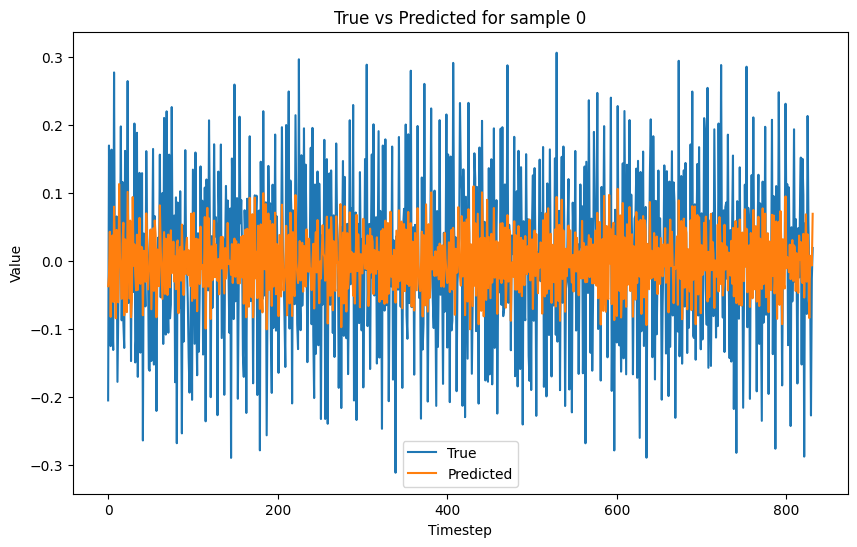

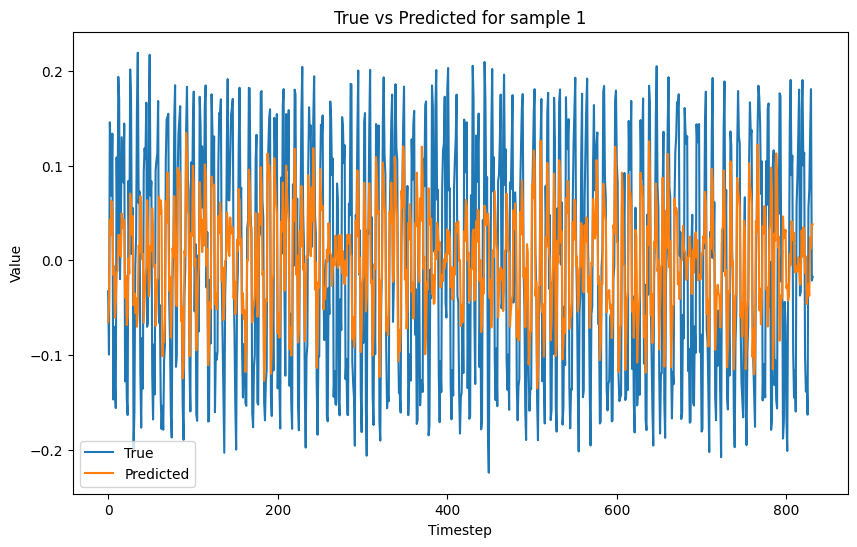

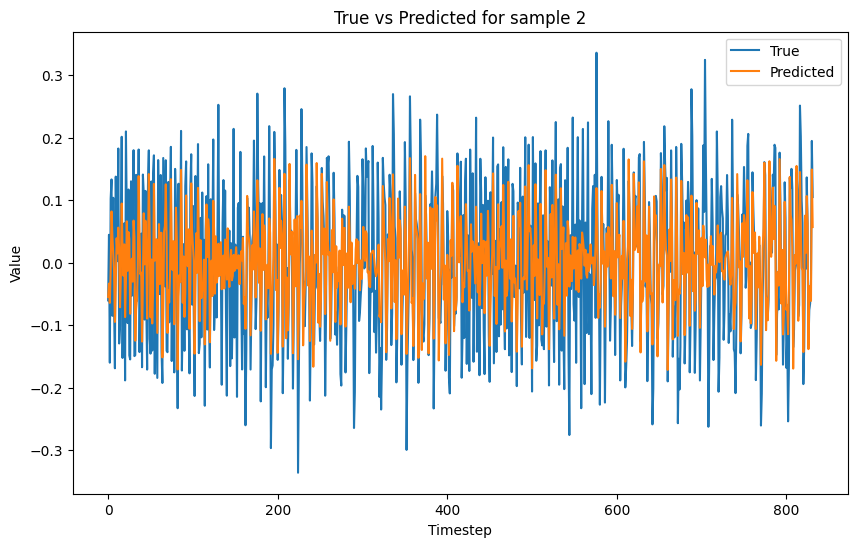

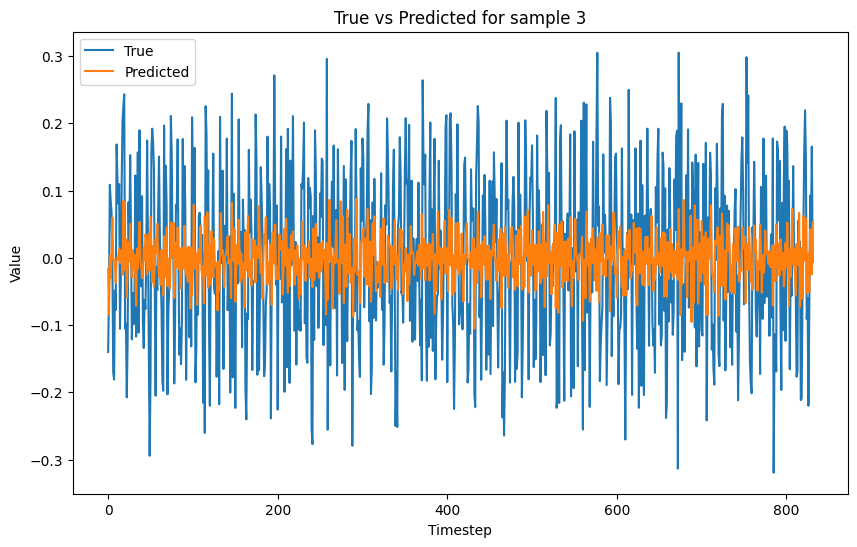

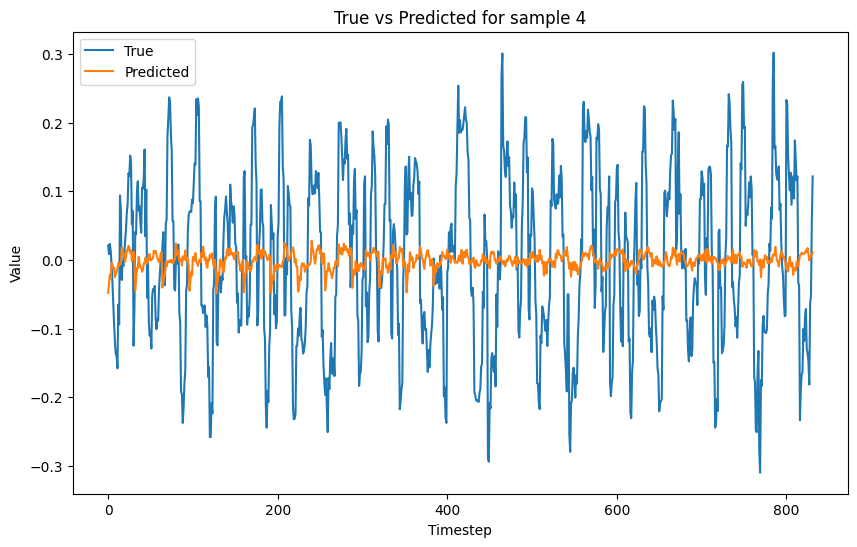

In [8]:
# Visualize Predictions for Different UEs
for sample_index in range(5):  # Change range to visualize different samples
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[sample_index], label='True')
    plt.plot(y_pred[sample_index], label='Predicted')
    plt.title(f'True vs Predicted for sample {sample_index}')
    plt.xlabel('Timestep')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
